# Explore and Validate Dataset

In [121]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("../../lightning_modules/jetGNN")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import yaml
from torch_geometric.data import Data
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explore Pre-processed Data

In [6]:
# Load the config file
config_file = "jet_tag_config.yaml"
with open(config_file, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [11]:
# Load some sample data
all_files = os.listdir(os.path.join(config["input_dir"], "train"))
sample_file = all_files[0]
sample_data = torch.load(os.path.join(config["input_dir"], "train", sample_file))

In [20]:
try:
    _ = sample_data[0].x
except Exception:
    for i, data in enumerate(sample_data):
        sample_data[i] = Data.from_dict(data.__dict__)

In [21]:
sample_data[0]

Data(x=[37, 4], y=0, log_pt=[37], log_E=[37], delta_eta=[37], delta_phi=[37], delta_pt=[37], delta_E=[37], delta_R=[37])

## Evaluate and re-process raw data

In [2]:
test_file = '/global/cfs/cdirs/m3443/data/JetTagging/top_tagging/raw_input/test.h5'
with pd.HDFStore(test_file, mode = 'r') as store:
    test_df = store['table']

In [4]:
# To reprocess and validate data, need to:
# 1. For each of train, val, test, load the HDF5 file
# 2. For each event in file, create Data object
# 3. Convert E, PX, PY, PZ to named node features
# 4. Construct higher features
# 5. Test this with ~10 events and plot the distribution of the features
# 6. If not well-normalized, then add normalization factors to each 
# - [E,px,py,pz,pt,eta,phi,jet_E,jet_pt,delta_eta,delta_phi] =/ [100, 100, 100, 100, 100, pi, pi, 1000, 1000, 1, 1]

In [40]:
def get_four_momenta(jet_tuple):
    energies = torch.tensor([getattr(jet_tuple, f'E_{i}') for i in range(200)])
    x_values = torch.tensor([getattr(jet_tuple, f'PX_{i}') for i in range(200)])
    y_values = torch.tensor([getattr(jet_tuple, f'PY_{i}') for i in range(200)])
    z_values = torch.tensor([getattr(jet_tuple, f'PZ_{i}') for i in range(200)])
    all_values = torch.stack([energies, x_values, y_values, z_values], dim=1)

    existing_jet_mask = energies > 0
    return all_values[existing_jet_mask]

def calc_kinematics(x, y, z):
    pt = np.sqrt(x**2 + y**2)
    theta = np.arctan2(pt, z)
    eta = -1. * np.log(np.tan(theta / 2.))
    phi = np.arctan2(y, x)
    
    return pt, eta, phi

def get_higher_features(p):
    
    E, x, y, z = p.T
    pt, eta, phi = calc_kinematics(x,y,z)
    
    jet_p4 = p.sum(0)        
    jet_pt, jet_eta, jet_phi = calc_kinematics(jet_p4[1], jet_p4[2], jet_p4[3])
    
    delta_eta = eta - jet_eta
    delta_phi = phi - jet_phi
    delta_phi[delta_phi > np.pi] -= 2 * np.pi
    delta_phi[delta_phi < -np.pi] += 2 * np.pi
    
    return pt, eta, phi, delta_eta, delta_phi, jet_p4, jet_pt, jet_eta, jet_phi

def build_all_features(jet):
    p = get_four_momenta(jet)
    y = torch.tensor(jet.is_signal_new)

    pt, eta, phi, delta_eta, delta_phi, jet_p4, jet_pt, jet_eta, jet_phi = get_higher_features(p)
    delta_pt = pt / jet_pt
    log_delta_pt = torch.log(delta_pt)
    delta_E = p[:, 0] / jet_p4[0]
    log_delta_E = torch.log(delta_E)
    delta_R = torch.sqrt( delta_eta**2 + delta_phi**2 )
    jet_mass = torch.sqrt(jet_p4[0]**2 - jet_p4[1]**2 - jet_p4[2]**2 - jet_p4[3]**2)

    pyg_jet = Data(pE=p[:, 0], px=p[:, 1], py=p[:, 2], pz=p[:, 3], 
                        y=y,
                        log_pt = torch.log(pt), 
                        log_E = torch.log(p[:, 0]),
                        delta_pt = delta_pt,
                        log_delta_pt = log_delta_pt,
                        delta_E = delta_E,
                        log_delta_E = log_delta_E,
                        delta_R = delta_R,
                        delta_eta = delta_eta,
                        delta_phi = delta_phi,
                        jet_pt = jet_pt,
                        jet_pE = jet_p4[0],
                        jet_px = jet_p4[1],
                        jet_py = jet_p4[2],
                        jet_pz = jet_p4[3],
                        jet_mass = jet_mass,
                        jet_eta = jet_eta,
                        jet_phi = jet_phi)

    # Convert all to float
    for key in pyg_jet.keys:
        pyg_jet[key] = pyg_jet[key].float()

    return pyg_jet

def process_jet_to_pyg(jet, feature_scales: dict = None):
    pyg_jet = build_all_features(jet)
    if feature_scales is not None:
        # Normalize the features
        for feature, scale in feature_scales.items():
            pyg_jet[feature] /= scale
    
    return pyg_jet

In [4]:
jet_tuple = test_df.iloc[0]

In [6]:
four_momenta = get_four_momenta(jet_tuple)

In [46]:
four_momenta_multievent = torch.cat([get_four_momenta(jet_tuple) for jet_tuple in test_df.iloc[:100].itertuples()])

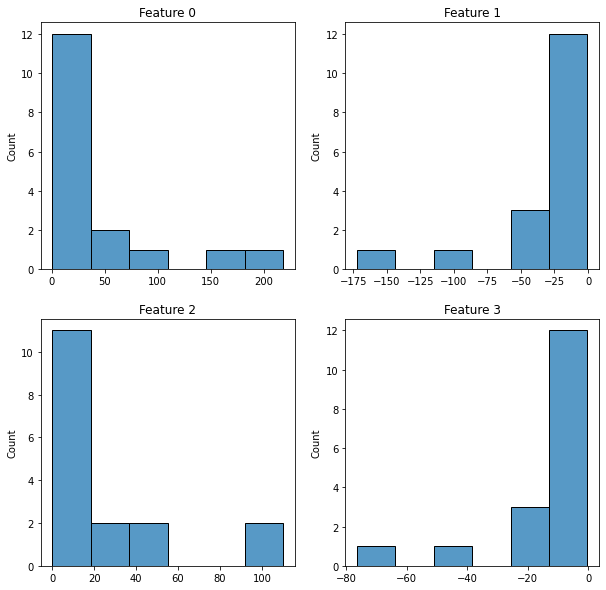

In [15]:
# Use seaborn to histogram each column of four-momenta, into four subplots

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(four_momenta[:, i], ax=ax)
    ax.set_title(f'Feature {i}')

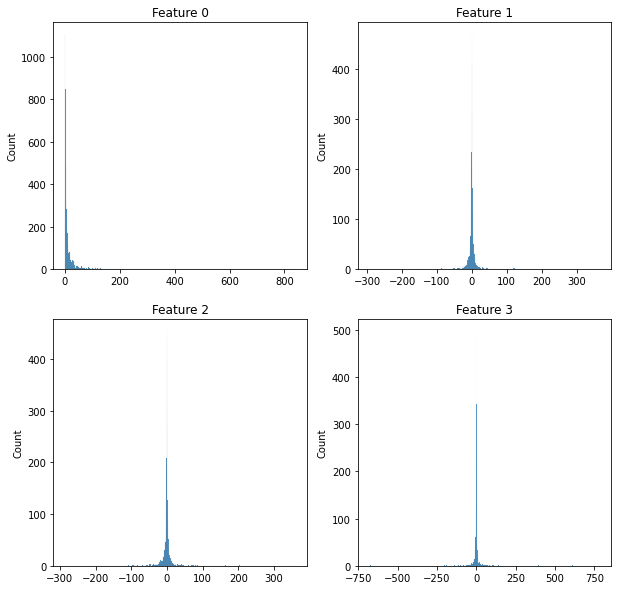

In [49]:
# Use seaborn to histogram each column of four-momenta, into four subplots

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(four_momenta_multievent[:, i], ax=ax)
    ax.set_title(f'Feature {i}')

In [47]:
pt, eta, phi = calc_kinematics(four_momenta_multievent[:, 1], four_momenta_multievent[:, 2], four_momenta_multievent[:, 3])

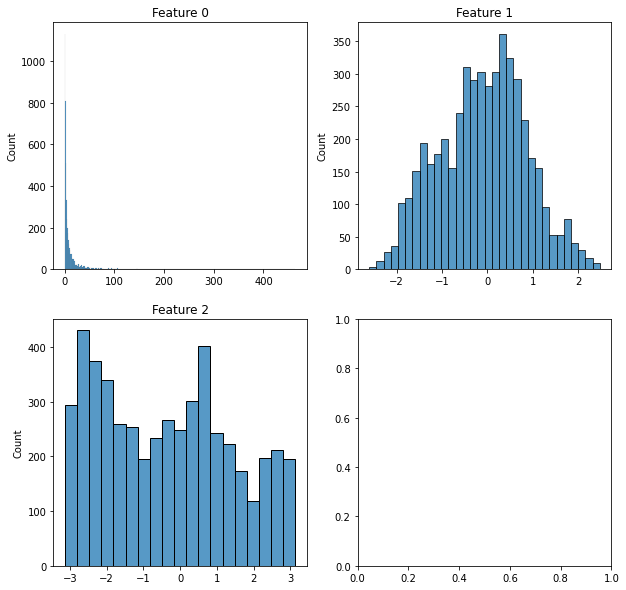

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# Plot pt, eta, phi in histograms  
for i, ax in zip([0, 1, 2], axes.flatten()):
    sns.histplot(eval(['pt', 'eta', 'phi'][i]), ax=ax)
    ax.set_title(f'Feature {i}')

In [75]:
kinematics_multievent = [get_higher_features(get_four_momenta(jet_tuple)) for jet_tuple in test_df.iloc[:100].itertuples()]

In [76]:
pt_multievent, eta_multievent, phi_multievent, jet_pt_multievent, delta_eta_multievent, delta_phi_multievent, jet_E_multievent = zip(*kinematics_multievent)

In [77]:
jet_pt_multievent = torch.stack(jet_pt_multievent)
jet_E_multievent = torch.stack(jet_E_multievent)
pt_multievent, eta_multievent, phi_multievent, delta_eta_multievent, delta_phi_multievent = [torch.cat(x) for x in [pt_multievent, eta_multievent, phi_multievent, delta_eta_multievent, delta_phi_multievent]]

IndexError: list index out of range

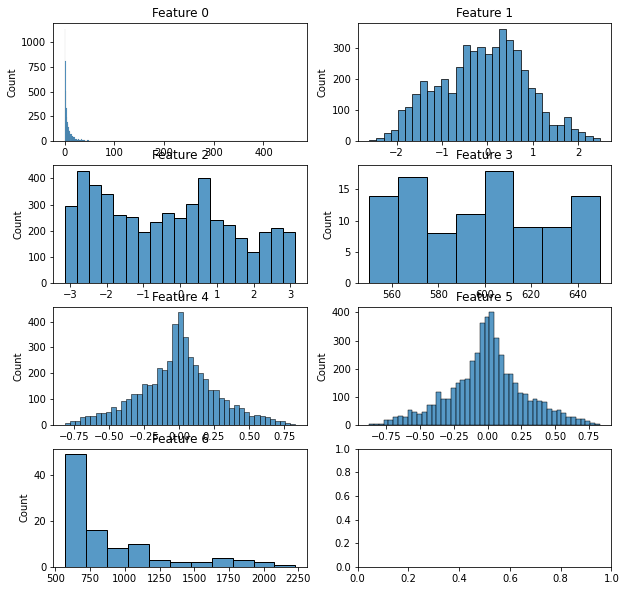

In [78]:
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
# Plot all kinematics
for i, ax in zip(range(8), axes.flatten()):
    sns.histplot(eval(['pt_multievent', 'eta_multievent', 'phi_multievent', 'jet_pt_multievent', 'delta_eta_multievent', 'delta_phi_multievent', 'jet_E_multievent'][i]), ax=ax)
    ax.set_title(f'Feature {i}')

## ParticleNet processing comparison

In [6]:
import awkward
import uproot_methods

In [7]:
def _transform(dataframe, start=0, stop=-1, jet_size=0.8):
    from collections import OrderedDict
    v = OrderedDict()

    df = dataframe.iloc[start:stop]
    def _col_list(prefix, max_particles=200):
        return ['%s_%d'%(prefix,i) for i in range(max_particles)]
    
    _px = df[_col_list('PX')].values
    _py = df[_col_list('PY')].values
    _pz = df[_col_list('PZ')].values
    _e = df[_col_list('E')].values
    
    mask = _e>0
    n_particles = np.sum(mask, axis=1)

    px = awkward.JaggedArray.fromcounts(n_particles, _px[mask])
    py = awkward.JaggedArray.fromcounts(n_particles, _py[mask])
    pz = awkward.JaggedArray.fromcounts(n_particles, _pz[mask])
    energy = awkward.JaggedArray.fromcounts(n_particles, _e[mask])

    p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, energy)
    pt = p4.pt

    jet_p4 = p4.sum()

    # outputs
    _label = df['is_signal_new'].values
    v['label'] = np.stack((_label, 1-_label), axis=-1)
    v['train_val_test'] = df['ttv'].values
    
    v['jet_pt'] = jet_p4.pt
    v['jet_eta'] = jet_p4.eta
    v['jet_phi'] = jet_p4.phi
    v['jet_mass'] = jet_p4.mass
    v['n_parts'] = n_particles

    v['part_px'] = px
    v['part_py'] = py
    v['part_pz'] = pz
    v['part_energy'] = energy

    v['part_pt_log'] = np.log(pt)
    v['part_ptrel'] = pt/v['jet_pt']
    v['part_logptrel'] = np.log(v['part_ptrel'])

    v['part_e_log'] = np.log(energy)
    v['part_erel'] = energy/jet_p4.energy
    v['part_logerel'] = np.log(v['part_erel'])

    v['part_raw_etarel'] = (p4.eta - v['jet_eta'])
    _jet_etasign = np.sign(v['jet_eta'])
    _jet_etasign[_jet_etasign==0] = 1
    v['part_etarel'] = v['part_raw_etarel'] * _jet_etasign

    v['part_phirel'] = p4.delta_phi(jet_p4)
    v['part_deltaR'] = np.hypot(v['part_etarel'], v['part_phirel'])

    def _make_image(var_img, rec, n_pixels = 64, img_ranges = [[-0.8, 0.8], [-0.8, 0.8]]):
        wgt = rec[var_img]
        x = rec['part_etarel']
        y = rec['part_phirel']
        img = np.zeros(shape=(len(wgt), n_pixels, n_pixels))
        for i in range(len(wgt)):
            hist2d, xedges, yedges = np.histogram2d(x[i], y[i], bins=[n_pixels, n_pixels], range=img_ranges, weights=wgt[i])
            img[i] = hist2d
        return img

#     v['img'] = _make_image('part_ptrel', v)

    return v

In [8]:
transformed_df = _transform(test_df, start=0, stop=1)

### Test equality

First, [E, x, y, z]

In [41]:
jet_tuple = test_df.iloc[0]
data = build_all_features(jet_tuple)

In [ ]:
data

Data(y=0.0, pE=[17], px=[17], py=[17], pz=[17], log_pt=[17], log_E=[17], delta_pt=[17], delta_E=[17], delta_R=[17], delta_eta=[17], delta_phi=[17], jet_pt=604.3117565048879, jet_E=645.1431658267975, jet_eta=-0.34639891305780834, jet_phi=2.4797033563045376)

In [ ]:
transformed_df.keys()

odict_keys(['label', 'train_val_test', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'n_parts', 'part_px', 'part_py', 'part_pz', 'part_energy', 'part_pt_log', 'part_ptrel', 'part_logptrel', 'part_e_log', 'part_erel', 'part_logerel', 'part_raw_etarel', 'part_etarel', 'part_phirel', 'part_deltaR'])

In [42]:
# Convert JaggedArray transformed_df to torch.tensor 

part_px_1 = torch.tensor(transformed_df["part_px"].tolist())
part_px_2 = data.px
print((part_px_1 == part_px_2).all())

part_py_1 = torch.tensor(transformed_df["part_py"].tolist())
part_py_2 = data.py
print((part_py_1 == part_py_2).all())

part_pz_1 = torch.tensor(transformed_df["part_pz"].tolist())
part_pz_2 = data.pz
print((part_pz_1 == part_pz_2).all())

part_energy_1 = torch.tensor(transformed_df["part_energy"].tolist())
part_energy_2 = data.pE
print((part_energy_1 == part_energy_2).all())

tensor(True)
tensor(True)
tensor(True)
tensor(True)


In [43]:
jet_pt_1 = torch.tensor(transformed_df["jet_pt"].tolist())
jet_pt_2 = data.jet_pt
print(jet_pt_1 == jet_pt_2)

jet_eta_1 = torch.tensor(transformed_df["jet_eta"].tolist())
jet_eta_2 = data.jet_eta
print(jet_eta_1 == jet_eta_2)

jet_phi_1 = torch.tensor(transformed_df["jet_phi"].tolist())
jet_phi_2 = data.jet_phi
print(jet_phi_1 == jet_phi_2)

tensor([True])
tensor([True])
tensor([True])


In [45]:
part_log_pt_1 = torch.tensor(transformed_df["part_pt_log"].tolist())
part_log_pt_2 = data.log_pt
print(torch.allclose(part_log_pt_1, part_log_pt_2))

part_ptrel_1 = torch.tensor(transformed_df["part_ptrel"].tolist())
part_ptrel_2 = data.delta_pt
print(torch.allclose(part_ptrel_1, part_ptrel_2))

part_log_ptrel_1 = torch.tensor(transformed_df["part_logptrel"].tolist())
part_log_ptrel_2 = data.log_delta_pt
print(torch.allclose(part_log_ptrel_1, part_log_ptrel_2))

part_erel_1 = torch.tensor(transformed_df["part_erel"].tolist())
part_erel_2 = data.delta_E
print(torch.allclose(part_erel_1, part_erel_2))

part_log_erel_1 = torch.tensor(transformed_df["part_logerel"].tolist())
part_log_erel_2 = data.log_delta_E
print(torch.allclose(part_log_erel_1, part_log_erel_2))

True
True
True
True
True


In [46]:
jet_mass_1 = torch.tensor(transformed_df["jet_mass"].tolist())
jet_mass_2 = data.jet_mass
print(torch.allclose(jet_mass_1, jet_mass_2))

True


## Get Normalization Scales

In [102]:
multi_jet = [process_jet_to_pyg(jet_tuple, feature_scales) for jet_tuple in test_df.iloc[:100].itertuples()]

In [103]:
multi_event_data = {}

for key in multi_jet[0].keys:
    if multi_jet[0][key].shape:
        multi_event_data[key] = torch.cat([jet[key] for jet in multi_jet])
    else:
        multi_event_data[key] = torch.stack([jet[key] for jet in multi_jet])

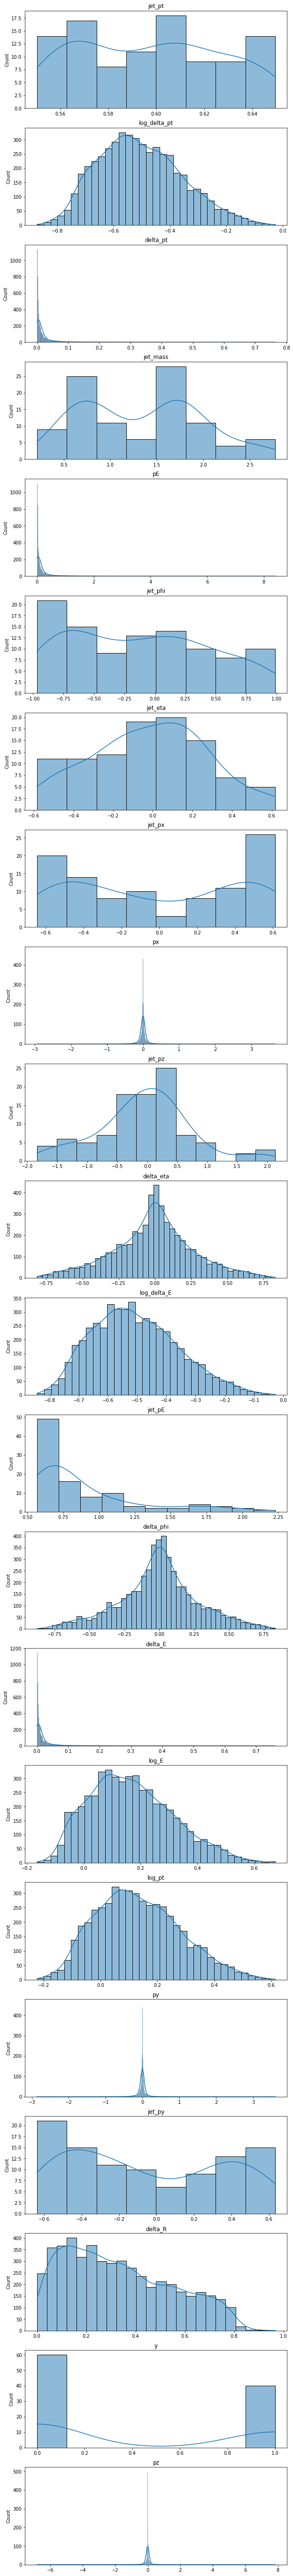

In [104]:
fig, axes = plt.subplots(len(multi_event_data.keys()), 1, figsize=(10, 100))
for i, key in enumerate(multi_event_data.keys()):
    sns.histplot(multi_event_data[key].numpy(), ax=axes[i], kde=True)
    axes[i].set_title(key)

In [101]:
feature_scales = {
    "jet_pt": 1000,
    "log_delta_pt": 10,
    "delta_pt": 1,
    "jet_mass": 100,
    "pE": 100,
    "jet_phi": np.pi,
    "jet_eta": np.pi,
    "jet_px": 1000,
    "px": 100,
    "jet_pz": 1000,
    "delta_eta": 1,
    "log_delta_E": 10,
    "jet_pE": 1000,
    "delta_phi": 1,
    "delta_E": 1,
    "log_E": 10,
    "log_pt": 10,
    "py": 100,
    "jet_py": 1000,
    "delta_R": 1,
    "pz": 100
}

In [94]:
jet_tuple = test_df.iloc[0]
pyg_jet = build_all_features(jet_tuple)

In [95]:
normed_jet = process_jet_to_pyg(jet_tuple, feature_scales)

In [96]:
pyg_jet

Data(y=0.0, pE=[17], px=[17], py=[17], pz=[17], log_pt=[17], log_E=[17], delta_pt=[17], log_delta_pt=[17], delta_E=[17], log_delta_E=[17], delta_R=[17], delta_eta=[17], delta_phi=[17], jet_pt=604.311767578125, jet_pE=645.1431884765625, jet_px=-476.70074462890625, jet_py=371.4150085449219, jet_pz=-213.5445098876953, jet_mass=73.59175872802734, jet_eta=-0.3463989198207855, jet_phi=2.479703426361084)

In [97]:
normed_jet

Data(y=0.0, pE=[17], px=[17], py=[17], pz=[17], log_pt=[17], log_E=[17], delta_pt=[17], log_delta_pt=[17], delta_E=[17], log_delta_E=[17], delta_R=[17], delta_eta=[17], delta_phi=[17], jet_pt=6.043117523193359, jet_pE=0.6451432108879089, jet_px=-0.4767007529735565, jet_py=0.37141501903533936, jet_pz=-0.21354450285434723, jet_mass=0.7359175682067871, jet_eta=-0.1102622002363205, jet_phi=0.7893140912055969)

## Process All Data

In [107]:
input_file = '/global/cfs/cdirs/m3443/data/JetTagging/top_tagging/raw_input/val.h5'
output_dir = '/global/cfs/cdirs/m3443/data/JetTagging/top_tagging/processed_input_pyg/val'

In [137]:
from tqdm.contrib.concurrent import process_map

def hdf5_to_pyg_event(jet_entry, output_dir, feature_scales):
    jet_tuple, jet_id = jet_entry
    return process_jet_to_pyg(jet_tuple, feature_scales)

def hdf5_to_pyg_events(input_file, output_dir, feature_scales, start=0, stop=None):
    with pd.HDFStore(input_file, mode = 'r') as store:
        jets_df = store['table']
    jets_df = jets_df.iloc[start:stop]
    os.makedirs(output_dir, exist_ok=True)
    print("Processing files")

    jet_batch = []
    batch_size = 100000
    for jet_id, jet_tuple in tqdm(jets_df.iterrows()):
        jet_batch.append(hdf5_to_pyg_event((jet_tuple, jet_id), output_dir, feature_scales))
        if len(jet_batch) == batch_size:
            torch.save(jet_batch, f"{output_dir}/{jet_id//batch_size}.pt")
            jet_batch = []

    # jet_list = zip(jets_df.itertuples(), range(len(jets_df)))
    # process_map(hdf5_to_pyg_event, jet_list, output_dir, feature_scales, max_workers=2)        

In [138]:
hdf5_to_pyg_events(input_file, output_dir, feature_scales, start=0)

Processing files


404000it [29:38, 227.18it/s]


In [134]:
test_files = os.listdir(output_dir)
test_files = [os.path.join(output_dir, file) for file in test_files]
sample = torch.load(test_files[0])

In [135]:
sample

Data(y=0.0, pE=[23], px=[23], py=[23], pz=[23], log_pt=[23], log_E=[23], delta_pt=[23], log_delta_pt=[23], delta_E=[23], log_delta_E=[23], delta_R=[23], delta_eta=[23], delta_phi=[23], jet_pt=0.5667928457260132, jet_pE=0.5876146554946899, jet_px=0.3440016806125641, jet_py=0.45046308636665344, jet_pz=0.14696787297725677, jet_mass=0.49369344115257263, jet_eta=0.0816388949751854, jet_phi=0.29240214824676514)